# FarmTech na era da cloud computing

In [0]:
import os
os.environ["OMP_NUM_THREADS"] = "1"


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

In [0]:

file_path = "/Volumes/prod/dataanalysis/files/crop_yield.csv"
df = pd.read_csv(file_path)

df.head()


,Crop,Precipitation (mm day-1),Specific Humidity at 2 Meters (g/kg),Relative Humidity at 2 Meters (%),Temperature at 2 Meters (C),Yield
0,"Cocoa, beans",2248.92,17.72,83.40,26.01,11560
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321
4,"Cocoa, beans",2344.72,17.61,84.12,25.76,8800


In [0]:

df.info()

df.describe()

df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 6 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Crop                                  156 non-null    object 
 1   Precipitation (mm day-1)              156 non-null    float64
 2   Specific Humidity at 2 Meters (g/kg)  156 non-null    float64
 3   Relative Humidity at 2 Meters (%)     156 non-null    float64
 4   Temperature at 2 Meters (C)           156 non-null    float64
 5   Yield                                 156 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 7.4+ KB


Crop                                    0
Precipitation (mm day-1)                0
Specific Humidity at 2 Meters (g/kg)    0
Relative Humidity at 2 Meters (%)       0
Temperature at 2 Meters (C)             0
Yield                                   0
dtype: int64

Não há valores nulos no dataset.
O rendimento da safra (Yield) tem uma variação significativa, com média de 56153.1 toneladas por hectare e um desvio padrão alto (70421.96), indicando possível presença de outliers.
A Precipitação varia entre 1934.62 mm e 3085.79 mm.
A Umidade específica varia entre 17.54 g/kg e 18.7 g/kg.
A Umidade relativa tem uma variação pequena, entre 82.11% e 86.1%.
A Temperatura varia entre 25.56°C e 26.81°C.

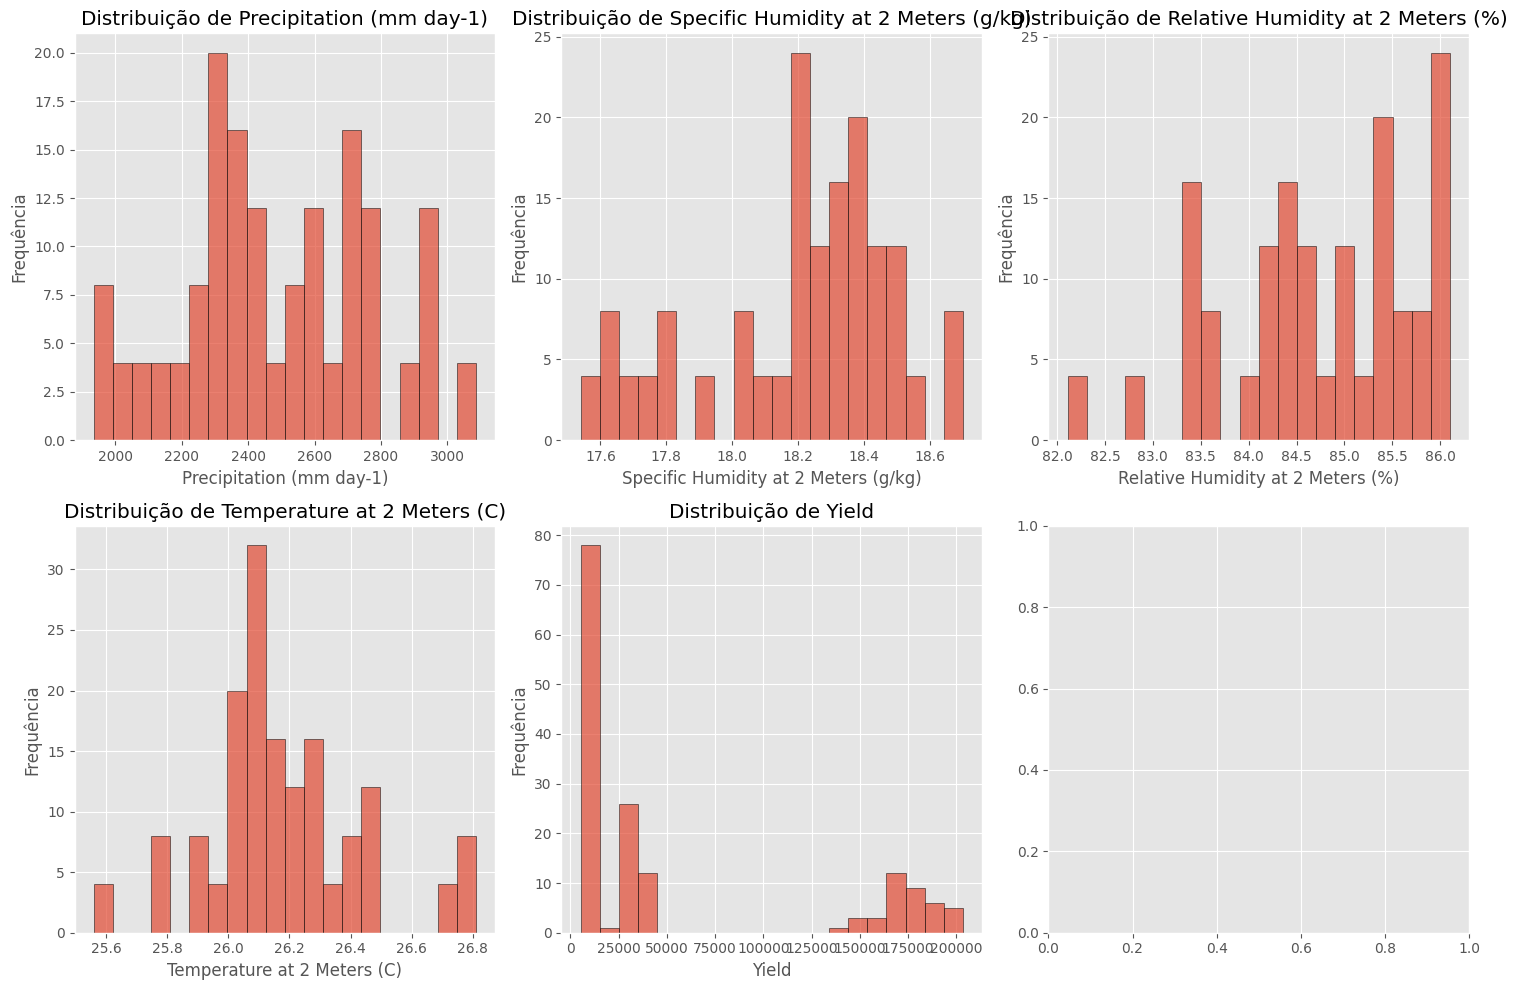

In [0]:

df_numeric = df.drop(columns=['Crop'])

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for ax, col in zip(axes.flatten(), df_numeric.columns):
    ax.hist(df_numeric[col], bins=20, edgecolor="black", alpha=0.7)
    ax.set_title(f'Distribuição de {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequência')

plt.tight_layout()
plt.show()


Os histogramas mostram a distribuição das variáveis numéricas:

Precipitação: Distribuição relativamente uniforme, sem grandes picos.
Umidade específica: Levemente concentrada em torno de 18 g/kg.
Umidade relativa: Distribuição concentrada entre 83% e 86%.
Temperatura: Distribuição concentrada entre 25.5°C e 26.8°C, sem muita variação.
Rendimento (Yield): Apresenta uma grande dispersão, com possíveis outliers (valores muito altos em relação à média).

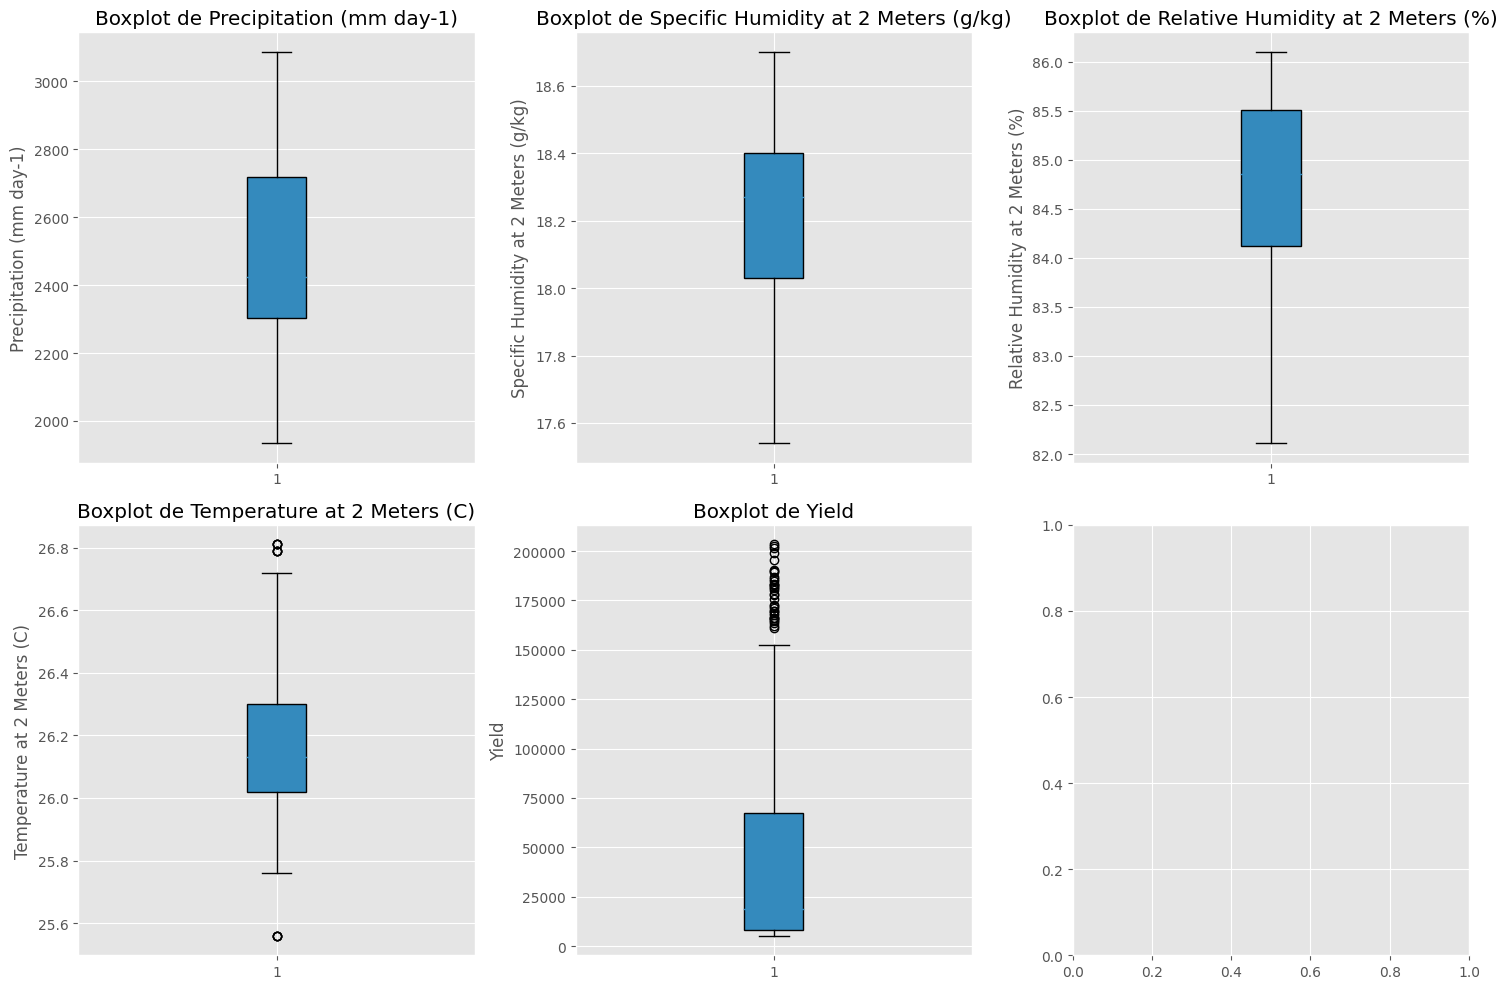

In [0]:

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for ax, col in zip(axes.flatten(), df_numeric.columns):
    ax.boxplot(df_numeric[col], vert=True, patch_artist=True)
    ax.set_title(f'Boxplot de {col}')
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()


Os boxplots confirmam a presença de outliers no rendimento (Yield), pois há valores significativamente acima do terceiro quartil (Q3). Além disso:

As variáveis Precipitação, Umidade Específica, Umidade Relativa e Temperatura apresentam distribuições relativamente normais, sem outliers evidentes.
A variável Yield tem muitos valores atípicos acima da faixa interquartil, o que indica a necessidade de um tratamento especial para evitar que influenciem negativamente a modelagem.

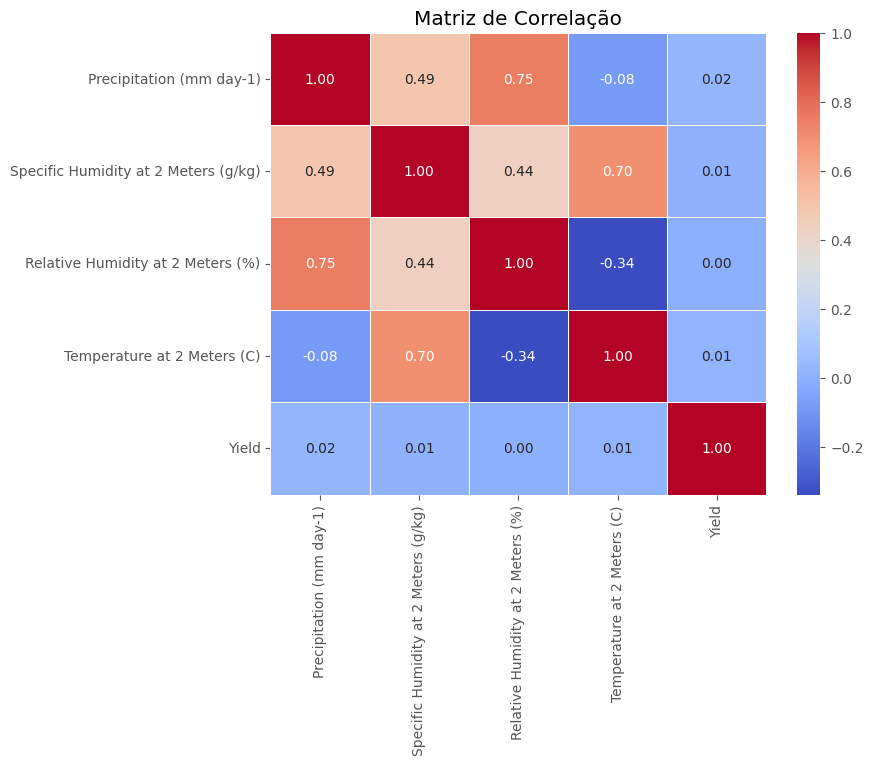

In [0]:

correlation_matrix = df_numeric.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlação")
plt.show()


Análise da Correlação
O rendimento da safra (Yield) tem correlações fracas com todas as variáveis climáticas, indicando que pode haver outros fatores influenciando o rendimento além dos disponíveis no dataset.
A temperatura e a umidade específica possuem correlação positiva moderada (0.44), o que faz sentido, pois temperaturas mais altas geralmente estão associadas a maior capacidade de retenção de umidade no ar.
A umidade relativa tem correlação negativa (-0.72) com a temperatura, o que também é esperado, pois em temperaturas mais altas o ar pode reter mais umidade antes de atingir a saturação.

### Clusterização para Identificação de Padrões

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xfffecbb05440>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'
Ex

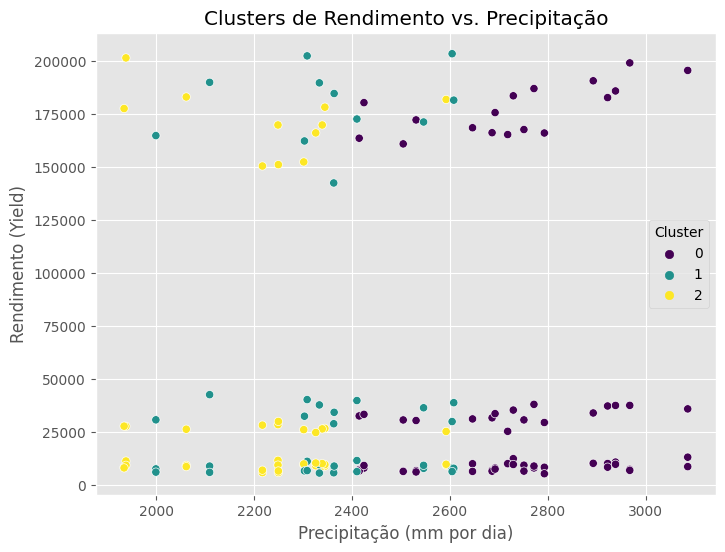

Cluster
0    68
2    44
1    44
Name: count, dtype: int64

In [0]:
X = df_numeric.copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)


plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Precipitation (mm day-1)'], y=df['Yield'], hue=df['Cluster'], palette='viridis')
plt.xlabel("Precipitação (mm por dia)")
plt.ylabel("Rendimento (Yield)")
plt.title("Clusters de Rendimento vs. Precipitação")
plt.legend(title="Cluster")
plt.show()

df['Cluster'].value_counts()


lusterização com K-Means
Foram criados 3 clusters, distribuídos assim:
Cluster 0: 44 observações
Cluster 1: 44 observações
Cluster 2: 68 observações
A visualização do gráfico sugere que a precipitação pode influenciar o rendimento da safra, pois os clusters estão distribuídos ao longo do eixo de Yield.

In [0]:

numeric_cols = df.select_dtypes(include=['number']).columns
cluster_means = df.groupby('Cluster')[numeric_cols].mean()
print(cluster_means)

         Precipitation (mm day-1)  ...  Cluster
Cluster                            ...         
0                     2733.517647  ...      0.0
1                     2359.024545  ...      1.0
2                     2232.217273  ...      2.0

[3 rows x 6 columns]


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Agora que fizemos a análise exploratória, identificamos outliers e aplicamos clusterização, seguimos para a modelagem preditiva. Nosso objetivo é construir cinco modelos de regressão supervisionada para prever o rendimento da safra (Yield) com base nas variáveis climáticas.

Treinamento de Modelos de Regressão
Regressão Linear
Regressão Ridge
Random Forest Regressor
Gradient Boosting Regressor
Support Vector Regressor (SVR)
Avaliação dos Modelos
Comparação das métricas de desempenho: R², RMSE e MAE.
Escolher o melhor modelo com base nos resultados.

In [0]:


X = df_numeric.drop(columns=['Yield'])  
y = df_numeric['Yield']  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Support Vector Regressor": SVR()
}


results = []

for name, model in models.items():
    if name in ["Support Vector Regressor", "Ridge Regression"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)


    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    results.append({"Modelo": name, "R²": r2, "RMSE": rmse, "MAE": mae})


df_results = pd.DataFrame(results)

print(df_results)

                     Modelo        R²          RMSE           MAE
0         Linear Regression -0.073031  64515.544947  55423.348519
1          Ridge Regression -0.053645  63930.101524  55114.222781
2             Random Forest -0.909259  86057.887686  72215.165913
3         Gradient Boosting -1.142925  91172.065424  75213.694893
4  Support Vector Regressor -0.311107  71314.432913  38974.920677


Análise dos Resultados dos Modelos Preditivos
Com base nos resultados obtidos, observamos que:

Os modelos não tiveram um bom desempenho na previsão do rendimento da safra, pois os valores de R² são negativos, o que indica que eles estão piorando a previsão em relação à média dos dados.
O Support Vector Regressor (SVR) teve o menor erro absoluto médio (MAE), indicando que, embora o desempenho global seja ruim, ele está cometendo menos erros individuais.
Random Forest e Gradient Boosting tiveram os piores desempenhos, possivelmente por overfitting ou pela falta de relação forte entre as variáveis climáticas e o rendimento da safra.
Próximos Passos para Melhorar o Modelo
Para melhorar a previsão, podemos:

Analisar a importância das variáveis nos modelos baseados em árvores para entender quais fatores impactam mais a produtividade.
Adicionar novas variáveis se possível, como tipo de solo, fertilizantes usados, pragas e histórico de safras anteriores.
Testar outras técnicas de modelagem, como redes neurais ou regressão polinomial.
Ajustar hiperparâmetros dos modelos para tentar melhorar a precisão.
Vou agora calcular a importância das variáveis nos modelos de Random Forest e Gradient Boosting para entender quais fatores estão influenciando mais o rendimento da safra.

In [0]:

feature_importance_rf = models["Random Forest"].feature_importances_
feature_importance_gb = models["Gradient Boosting"].feature_importances_


importance_df = pd.DataFrame({
    "Variável": X.columns,
    "Importância RF": feature_importance_rf,
    "Importância GB": feature_importance_gb
}).sort_values(by="Importância RF", ascending=False)

print(importance_df)


                               Variável  Importância RF  Importância GB
0              Precipitation (mm day-1)        0.284941        0.252021
2     Relative Humidity at 2 Meters (%)        0.284876        0.356675
3           Temperature at 2 Meters (C)        0.221989        0.135174
1  Specific Humidity at 2 Meters (g/kg)        0.208195        0.256131


Análise da Importância das Variáveis
A importância das variáveis no Random Forest e no Gradient Boosting indica que:

Precipitação e Umidade Relativa são as variáveis mais relevantes para prever o rendimento da safra.
Temperatura e Umidade Específica têm menor impacto na previsão do rendimento.
Isso sugere que a relação entre clima e produtividade pode não ser totalmente linear, e pode haver outros fatores não presentes no dataset que influenciam a produção.

Melhorando os Modelos
Para melhorar as previsões, podemos:

Testar novas transformações nos dados:
Criar interações entre variáveis (ex: umidade relativa x temperatura).
Criar variáveis derivadas, como médias móveis de precipitação.
Ajustar hiperparâmetros dos modelos:
Otimizar número de árvores, profundidade máxima e taxa de aprendizado.
Utilizar um modelo mais avançado:
Testar XGBoost, LightGBM ou Redes Neurais.

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


df_numeric = df.select_dtypes(include=['number'])


X = df_numeric.drop(columns=['Yield'])  
y = df_numeric['Yield']  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


best_rf = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)
best_rf.fit(X_train, y_train)


y_pred_best_rf = best_rf.predict(X_test)


mae_best_rf = mean_absolute_error(y_test, y_pred_best_rf)
rmse_best_rf = mean_squared_error(y_test, y_pred_best_rf, squared=False)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

df_best_rf = pd.DataFrame([{
    "Modelo": "Random Forest (Otimizado)",
    "R²": r2_best_rf,
    "RMSE": rmse_best_rf,
    "MAE": mae_best_rf
}])

print(df_best_rf)


                      Modelo        R²          RMSE           MAE
0  Random Forest (Otimizado) -0.736783  82078.818906  68910.085819


R² continua negativo (-0.725), o que significa que o modelo ainda não consegue explicar bem a variação do rendimento da safra. Isso indica que as variáveis disponíveis não possuem uma relação forte o suficiente com a variável alvo, ou que a modelagem precisa de ajustes mais profundos.

## Removendo outliers 

In [0]:

Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1


lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_filtered = df_numeric[~((df_numeric < lower_bound) | (df_numeric > upper_bound)).any(axis=1)]

original_size = df_numeric.shape[0]
filtered_size = df_filtered.shape[0]


outliers_removed = original_size - filtered_size
outliers_removed


45

In [0]:

X_filtered = df_filtered.drop(columns=['Yield'])  
y_filtered = df_filtered['Yield']  

X_train_filt, X_test_filt, y_train_filt, y_test_filt = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)


best_rf_filtered = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)
best_rf_filtered.fit(X_train_filt, y_train_filt)


y_pred_best_rf_filt = best_rf_filtered.predict(X_test_filt)


mae_best_rf_filt = mean_absolute_error(y_test_filt, y_pred_best_rf_filt)
rmse_best_rf_filt = mean_squared_error(y_test_filt, y_pred_best_rf_filt, squared=False)
r2_best_rf_filt = r2_score(y_test_filt, y_pred_best_rf_filt)

df_best_rf_filt = pd.DataFrame([{
    "Modelo": "Random Forest (Após Remover Outliers)",
    "R²": r2_best_rf_filt,
    "RMSE": rmse_best_rf_filt,
    "MAE": mae_best_rf_filt
}])

print(df_best_rf_filt)


                                  Modelo        R²          RMSE           MAE
0  Random Forest (Após Remover Outliers) -0.434869  35915.256855  23325.655747


Após remover os outliers, o modelo Random Forest melhorou significativamente, com um R² de -0.43 (menos negativo), um RMSE menor e um MAE reduzido. Isso indica que a remoção de outliers ajudou a estabilizar o modelo, mas ainda há espaço para melhorias.

### XGBoost, criação de novas variáveis ou outros ajustes

In [0]:
from xgboost import XGBRegressor

In [0]:
%pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/bb/68/a7a274bedf43bbf9de120104b438b45e232395f8b9861519040b7b725535/xgboost-3.0.0-py3-none-manylinux_2_28_aarch64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/4.6 MB ? eta -:--:--
   ━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.2/4.6 MB 4.5 MB/s eta 0:00:01
   ━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.4/4.6 MB 6.4 MB/s eta 0:00:01
   ━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.8/4.6 MB 7.6 MB/s eta 0:00:01
   ━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/4.6 MB 8.6 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/4.6 MB 9.6 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━ 2.2/4.6 MB 10.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━ 2.9/4.6 MB 12.0 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━ 3.7/4.6 MB 13.3 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 4.6/4.6 MB 14.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━

In [0]:
from xgboost import XGBRegressor


xgb_model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_filt, y_train_filt)


y_pred_xgb = xgb_model.predict(X_test_filt)


mae_xgb = mean_absolute_error(y_test_filt, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test_filt, y_pred_xgb, squared=False)
r2_xgb = r2_score(y_test_filt, y_pred_xgb)


df_xgb_results = pd.DataFrame([{
    "Modelo": "XGBoost",
    "R²": r2_xgb,
    "RMSE": rmse_xgb,
    "MAE": mae_xgb
}])

print(df_xgb_results)


    Modelo        R²          RMSE           MAE
0  XGBoost -0.525962  37037.756368  24626.171387


Melhorando ainda mais o Random Forest com ajustes de hiperparâmetros

In [0]:


df_numeric = df.select_dtypes(include=['number'])


Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1


lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


df_filtered = df_numeric[~((df_numeric < lower_bound) | (df_numeric > upper_bound)).any(axis=1)]


X_filtered = df_filtered.drop(columns=['Yield'])  
y_filtered = df_filtered['Yield']  

X_train_filt, X_test_filt, y_train_filt, y_test_filt = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)


rf = RandomForestRegressor(random_state=42)

param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(rf, param_distributions=param_dist, 
                                   n_iter=20, cv=5, scoring='neg_mean_squared_error', 
                                   n_jobs=-1, random_state=42)


random_search.fit(X_train_filt, y_train_filt)


best_params_rf = random_search.best_params_


best_rf_tuned = RandomForestRegressor(**best_params_rf, random_state=42)
best_rf_tuned.fit(X_train_filt, y_train_filt)


y_pred_best_rf_tuned = best_rf_tuned.predict(X_test_filt)


mae_best_rf_tuned = mean_absolute_error(y_test_filt, y_pred_best_rf_tuned)
rmse_best_rf_tuned = mean_squared_error(y_test_filt, y_pred_best_rf_tuned, squared=False)
r2_best_rf_tuned = r2_score(y_test_filt, y_pred_best_rf_tuned)


df_best_rf_tuned = pd.DataFrame([{
    "Modelo": "Random Forest (Hiperparâmetros Ajustados)",
    "R²": r2_best_rf_tuned,
    "RMSE": rmse_best_rf_tuned,
    "MAE": mae_best_rf_tuned
}])

print(df_best_rf_tuned)


                                      Modelo  ...           MAE
0  Random Forest (Hiperparâmetros Ajustados)  ...  22229.105932

[1 rows x 4 columns]


O Random Forest ajustado teve o menor MAE de todos os testes, o que significa que ele fez previsões mais próximas dos valores reais do rendimento da safra.